In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Required libraries

In [2]:
# https://github.com/ranaroussi/yfinance/issues/2001
!pip install -q yfinance
# https://github.com/ranaroussi/yfinance/issues/764
# !pip install --upgrade yfinance

In [3]:
!pip install -q fix-yahoo-finance

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import fix_yahoo_finance as yfix

# yfix.pdr_override()

from datetime import datetime


from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM

/opt/conda/lib/python3.10/site-packages/fix_yahoo_finance/__init__.py:0: DeprecationWarning: 

*** `fix_yahoo_finance` was renamed to `yfinance`. ***
Please install and use `yfinance` directly using `pip install yfinance -U`

More information: https://github.com/ranaroussi/yfinance



# Getting the Data

We will be using yfinance available in python to download historical data required in our analysis

In [5]:
tech_list = ['NVDA', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    
company_list = [NVDA, GOOG, MSFT, AMZN]
company_name = ['NVIDIA', 'GOOGLE', 'MICROSOFT', 'AMAZON']

for company , com_name in zip(company_list, company_name):
    company['company_name'] = com_name


df = pd.concat(company_list)
df.dropna()
df.tail(10)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-08-23,177.339996,178.970001,175.240005,177.039993,177.039993,29150100,AMAZON
2024-08-26,176.699997,177.470001,174.300003,175.500000,175.500000,22366200,AMAZON
2024-08-27,174.149994,174.889999,172.250000,173.119995,173.119995,29842000,AMAZON
2024-08-28,173.690002,173.690002,168.919998,170.800003,170.800003,29045000,AMAZON
2024-08-29,173.220001,174.289993,170.809998,172.119995,172.119995,26407800,AMAZON
2024-08-30,172.779999,178.899994,172.600006,178.500000,178.500000,43429400,AMAZON
2024-09-03,177.550003,178.259995,175.259995,176.250000,176.250000,37735500,AMAZON
2024-09-04,174.479996,175.979996,172.539993,173.330002,173.330002,30309200,AMAZON
2024-09-05,175.000000,179.880005,175.000000,177.889999,177.889999,40170500,AMAZON


### Descriptive Stats about the data

In [6]:
NVDA.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,80.082227,81.592151,78.359108,80.037880,80.031545,4.370610e+08
std,30.565930,31.270804,29.591543,30.408669,30.411511,1.371777e+08
min,40.450001,40.879002,39.230000,40.326000,40.317253,1.739110e+08
25%,48.384501,49.008001,47.717499,48.288500,48.278023,3.500395e+08
50%,83.818001,84.323997,80.264000,82.632004,82.625214,4.167840e+08
75%,107.064999,110.360001,103.775002,106.839500,106.835129,4.954875e+08
max,139.800003,140.759995,132.419998,135.580002,135.580002,1.142269e+09


### Information about the data

In [7]:
NVDA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2023-09-08 to 2024-09-06
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Adj Close     251 non-null    float64
 5   Volume        251 non-null    int64  
 6   company_name  251 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB


## Closing Price

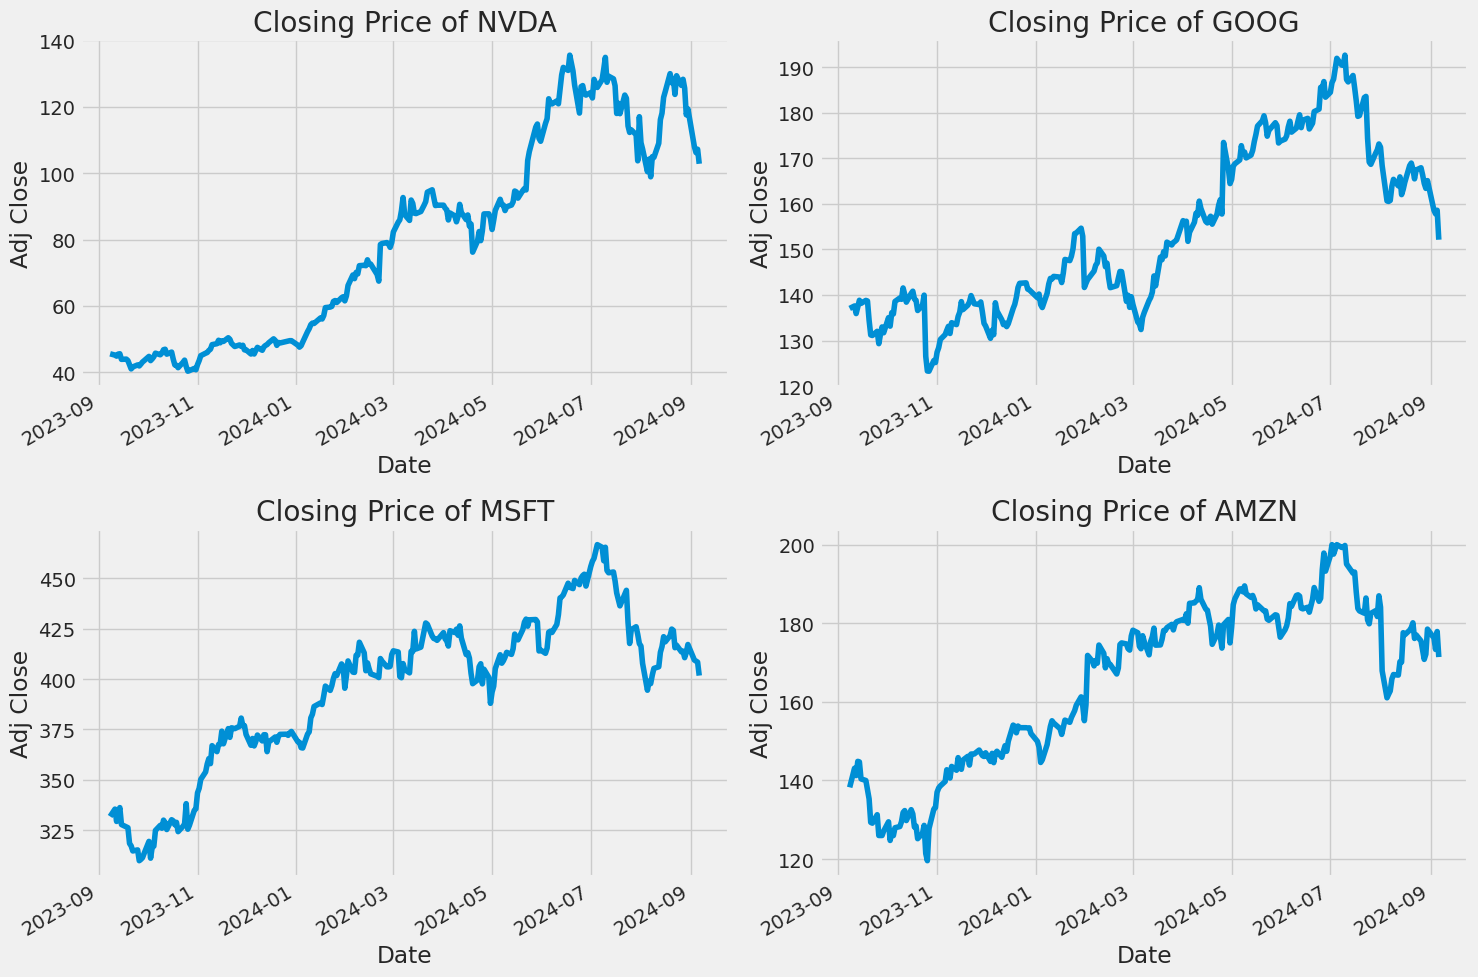

In [8]:
plt.figure(figsize = (15, 10))
plt.subplots_adjust(top = 1.25, bottom = 1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.title(f'Closing Price of {tech_list[i-1]}')
    
plt.tight_layout()

## Volume of Sales

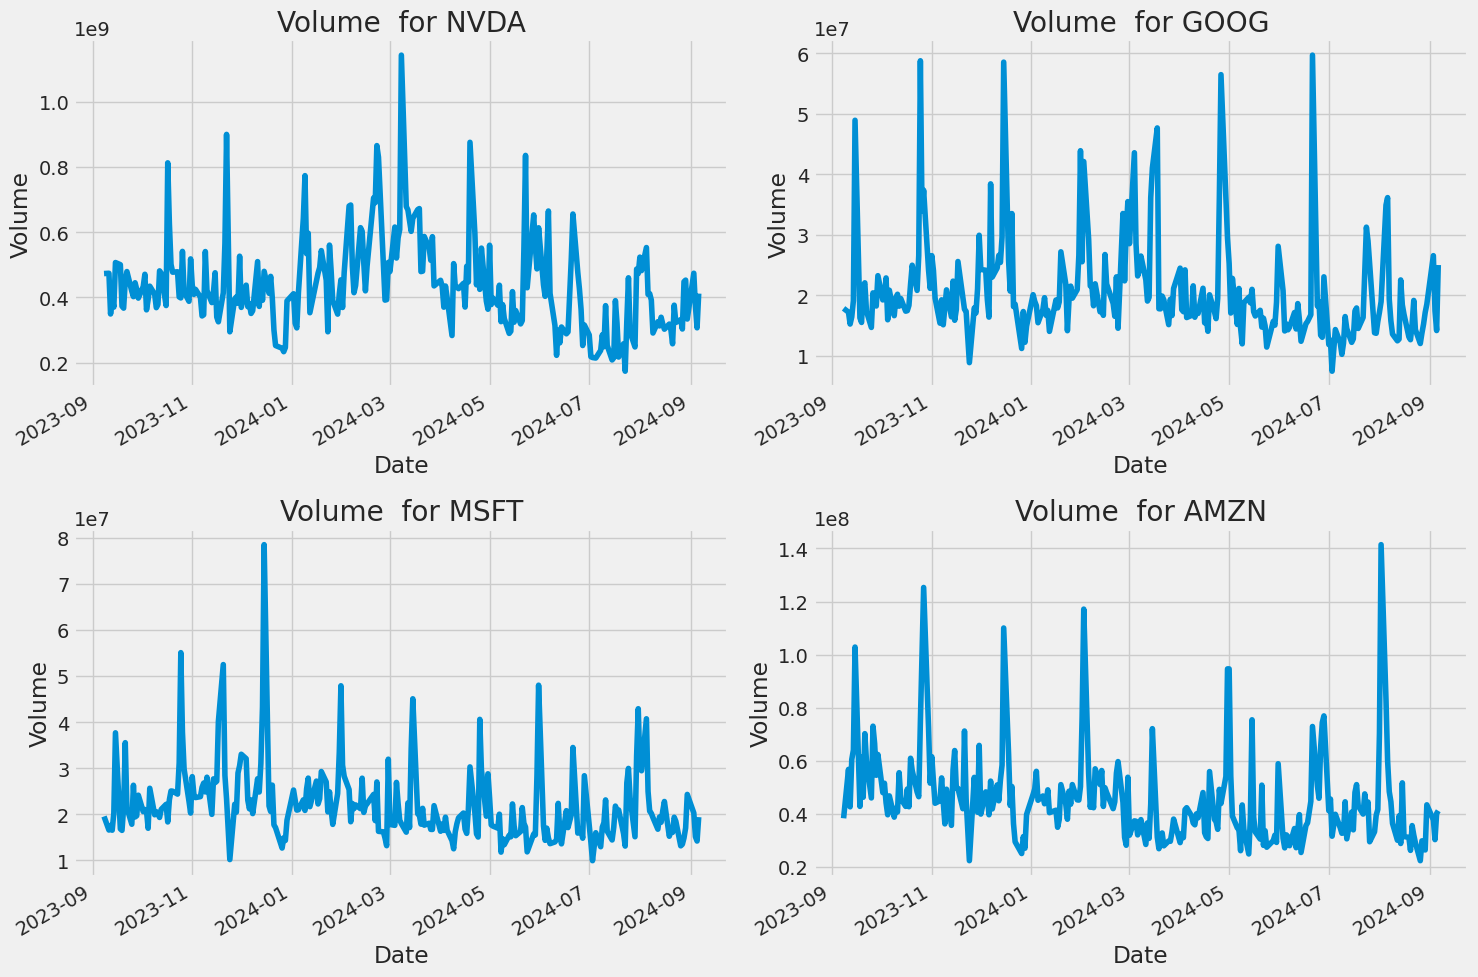

In [9]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i , company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.title(f'Volume  for {tech_list[i-1]}')
    
plt.tight_layout()

# Moving Average

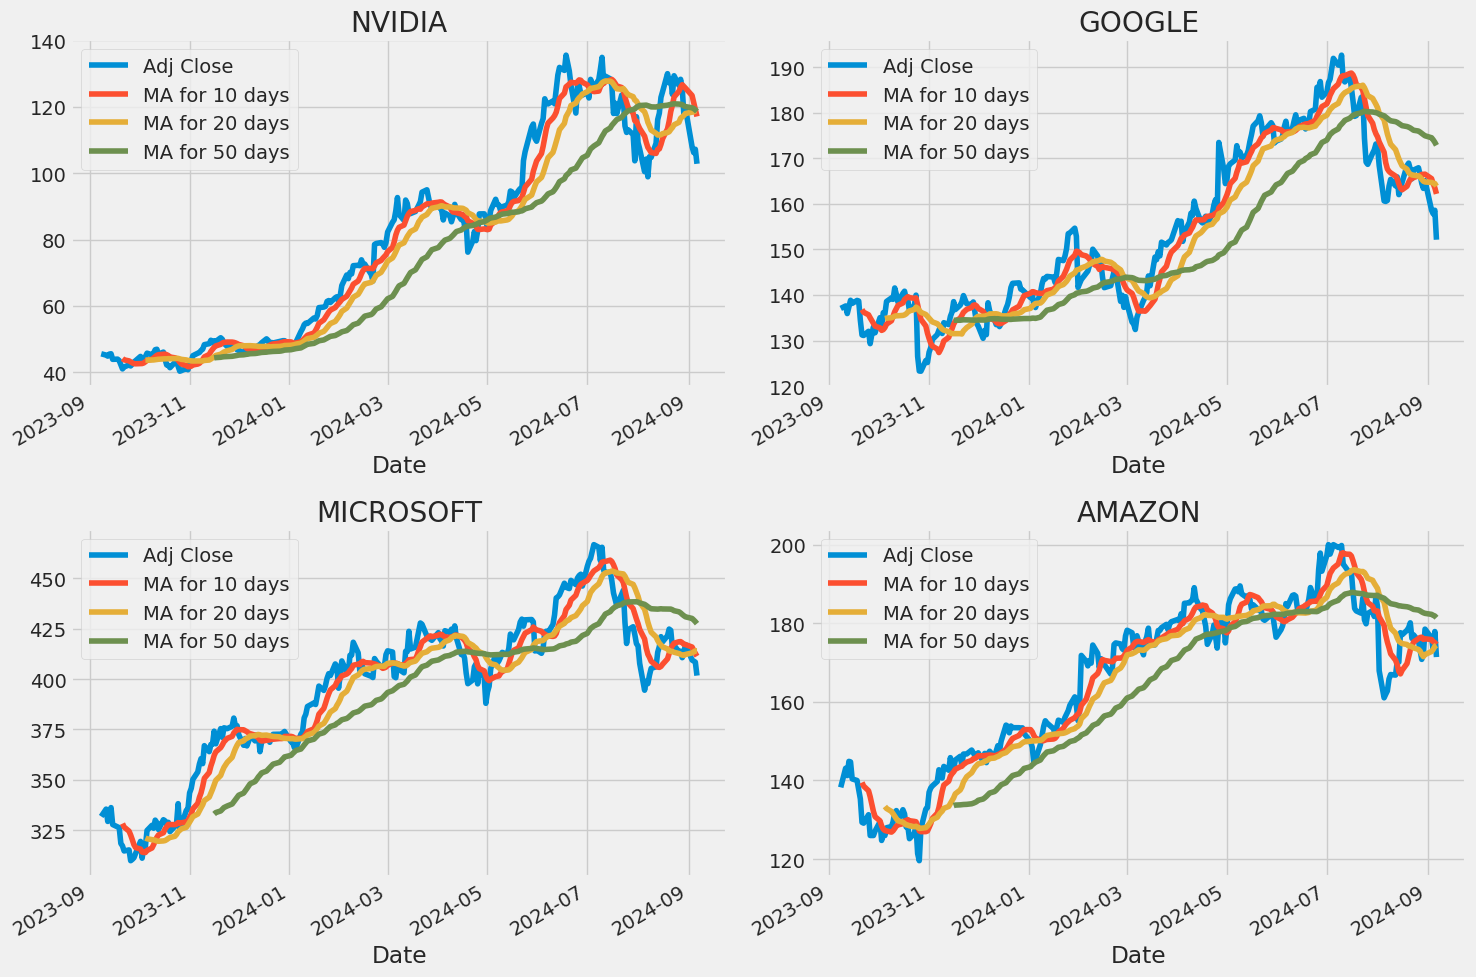

In [10]:
# Moving Average period list
ma_days = [10, 20, 50]

for ma in ma_days:
    for company in company_list:
        column_name = f'MA for {ma} days'
        company[column_name] = company['Adj Close'].rolling(ma).mean()
        
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_figheight(10)
fig.set_figwidth(15)

NVDA[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax = axes[0, 0])

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax = axes[0, 1])

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax = axes[1, 0])

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax = axes[1, 1])

axes[0, 0].set_title('NVIDIA')
axes[0, 1].set_title('GOOGLE')
axes[1, 0].set_title('MICROSOFT')
axes[1, 1].set_title('AMAZON')

fig.tight_layout()

# Daily Return

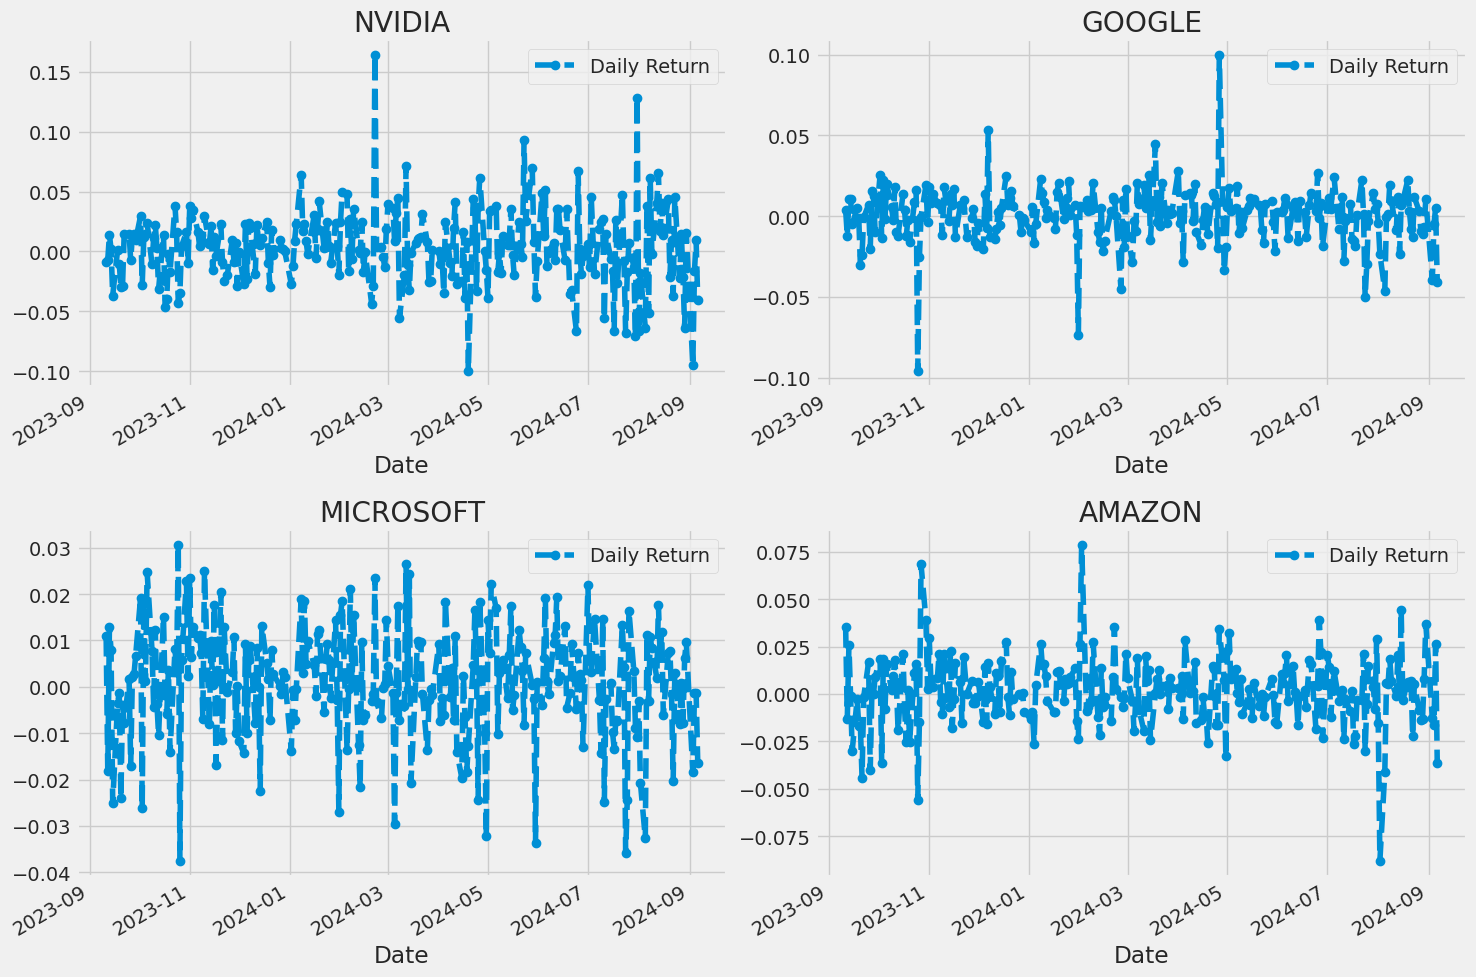

In [11]:
#pct_change - percentage change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()
    
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_figheight(10)
fig.set_figwidth(15)

NVDA['Daily Return'].plot(ax = axes[0, 0], legend = True , linestyle='--', marker = 'o')

GOOG['Daily Return'].plot(ax = axes[0, 1], legend = True , linestyle='--', marker = 'o')

MSFT['Daily Return'].plot(ax = axes[1, 0], legend = True , linestyle='--', marker = 'o')

AMZN['Daily Return'].plot(ax = axes[1, 1], legend = True , linestyle='--', marker = 'o')


axes[0, 0].set_title('NVIDIA')
axes[0, 1].set_title('GOOGLE')
axes[1, 0].set_title('MICROSOFT')
axes[1, 1].set_title('AMAZON')
fig.tight_layout()


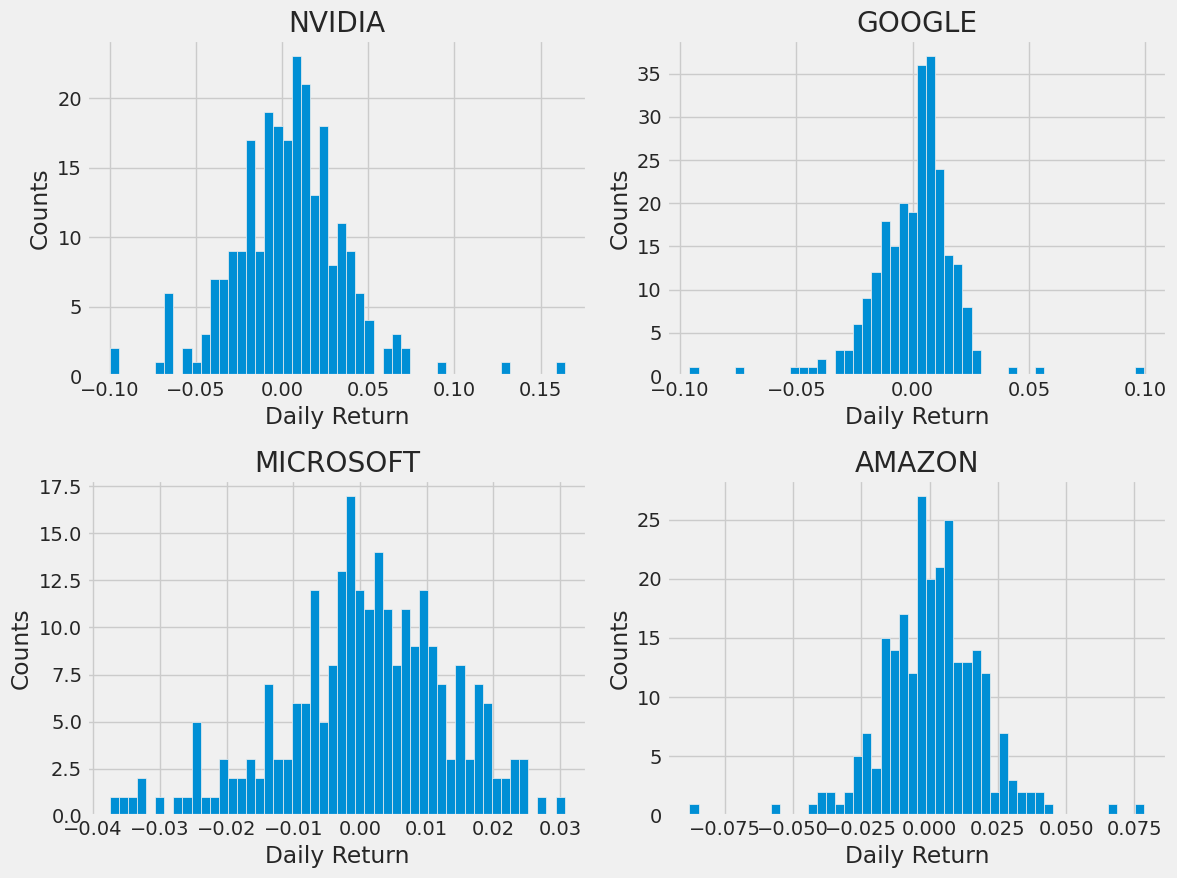

In [12]:
plt.figure(figsize=(12, 9))

for i , company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i-1]}')
    
plt.tight_layout()

# Correlation between stocks closing price

In [13]:
tech_list = ['NVDA', 'GOOG','MSFT', 'AMZN' ]

yfix.pdr_override(tech_list)

closing_df = yf.download(tech_list, start = start, end = end)['Adj Close']


tech_returns = closing_df.pct_change()
tech_returns.head()

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  4 of 4 completed


Ticker,AMZN,GOOG,MSFT,NVDA
Date,,,,
2023-09-08 00:00:00+00:00,NaN,NaN,NaN,NaN
2023-09-11 00:00:00+00:00,0.035231,0.003936,0.010979,-0.008646
2023-09-12 00:00:00+00:00,-0.013068,-0.012124,-0.018258,-0.006817
2023-09-13 00:00:00+00:00,0.025632,0.010509,0.012931,0.013706
2023-09-14 00:00:00+00:00,-0.000898,0.010836,0.007856,0.002111


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


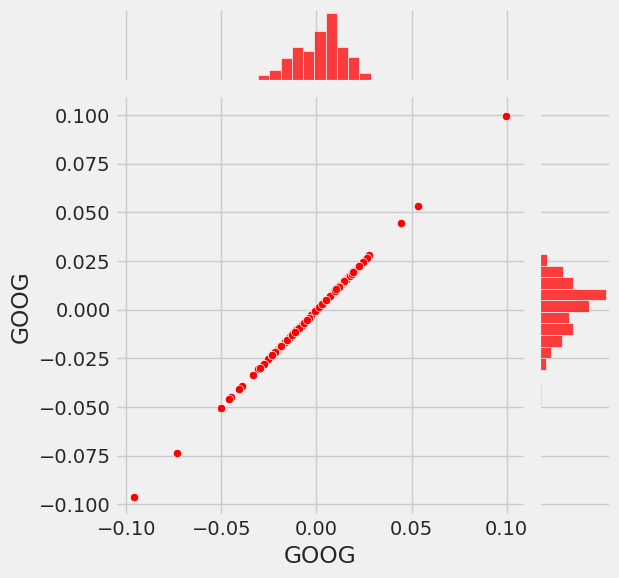

In [14]:
sns.jointplot(x = 'GOOG', y = 'GOOG', data = tech_returns, kind = 'scatter', color = 'red')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


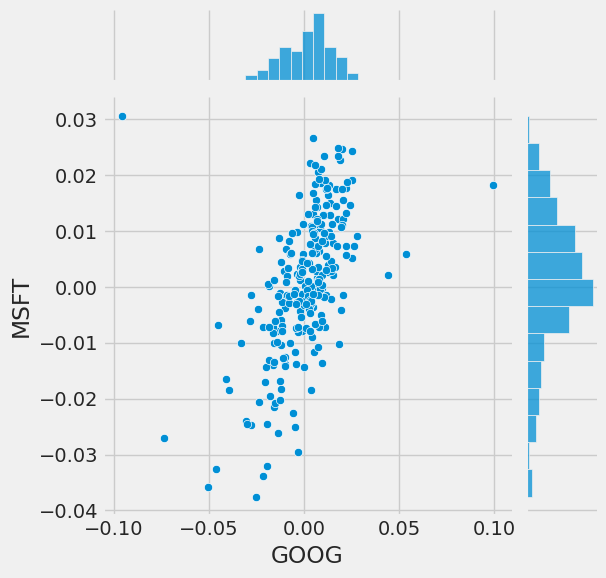

In [15]:
sns.jointplot(x = 'GOOG', y = 'MSFT', data = tech_returns, kind = 'scatter')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

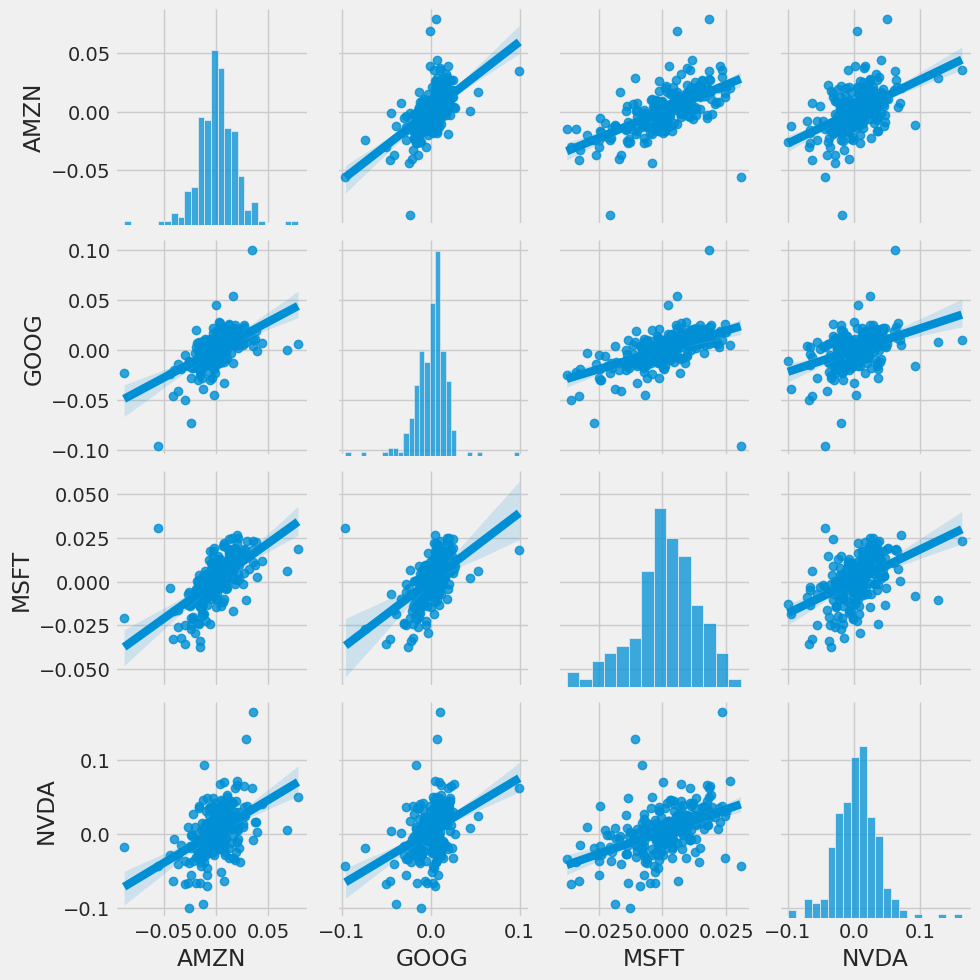

In [16]:
sns.pairplot(tech_returns, kind = 'reg')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

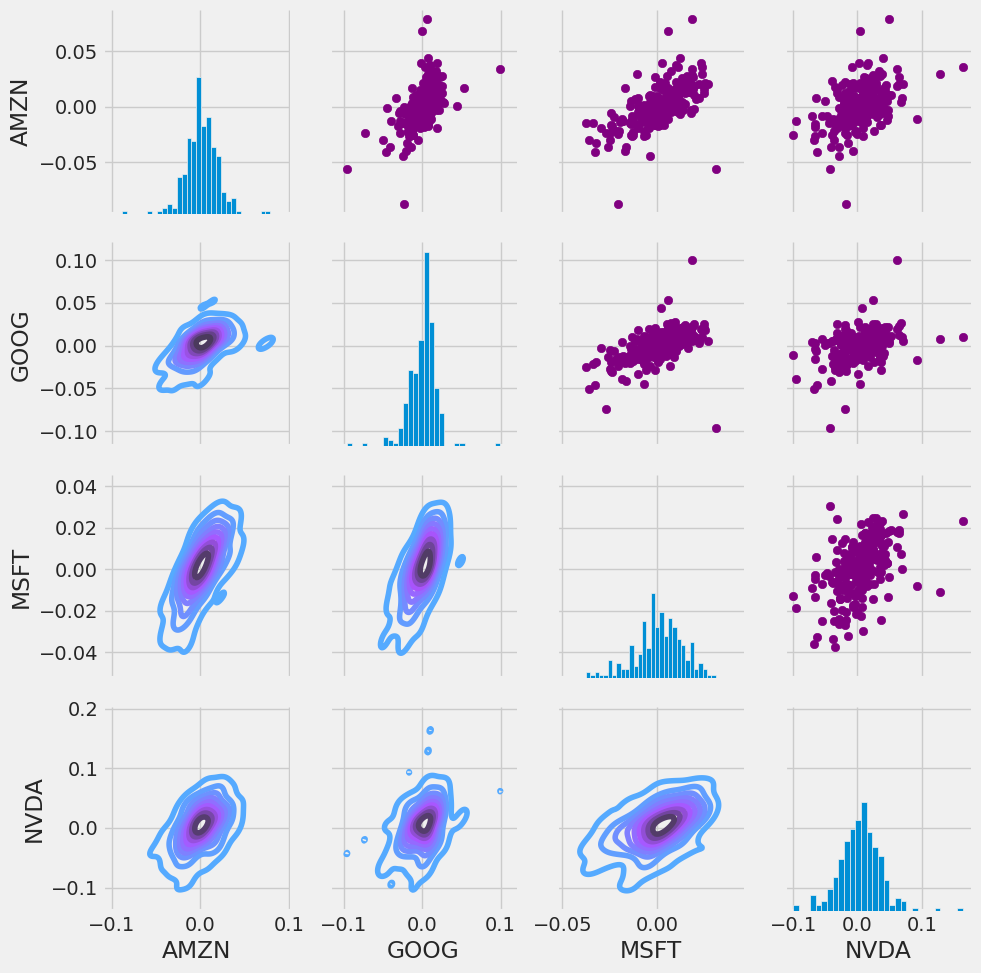

In [17]:
returns_fig = sns.PairGrid(tech_returns.dropna())

returns_fig.map_upper(plt.scatter, color = 'purple')
returns_fig.map_lower(sns.kdeplot, cmap = 'cool_d')

returns_fig.map_diag(plt.hist, bins = 30)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

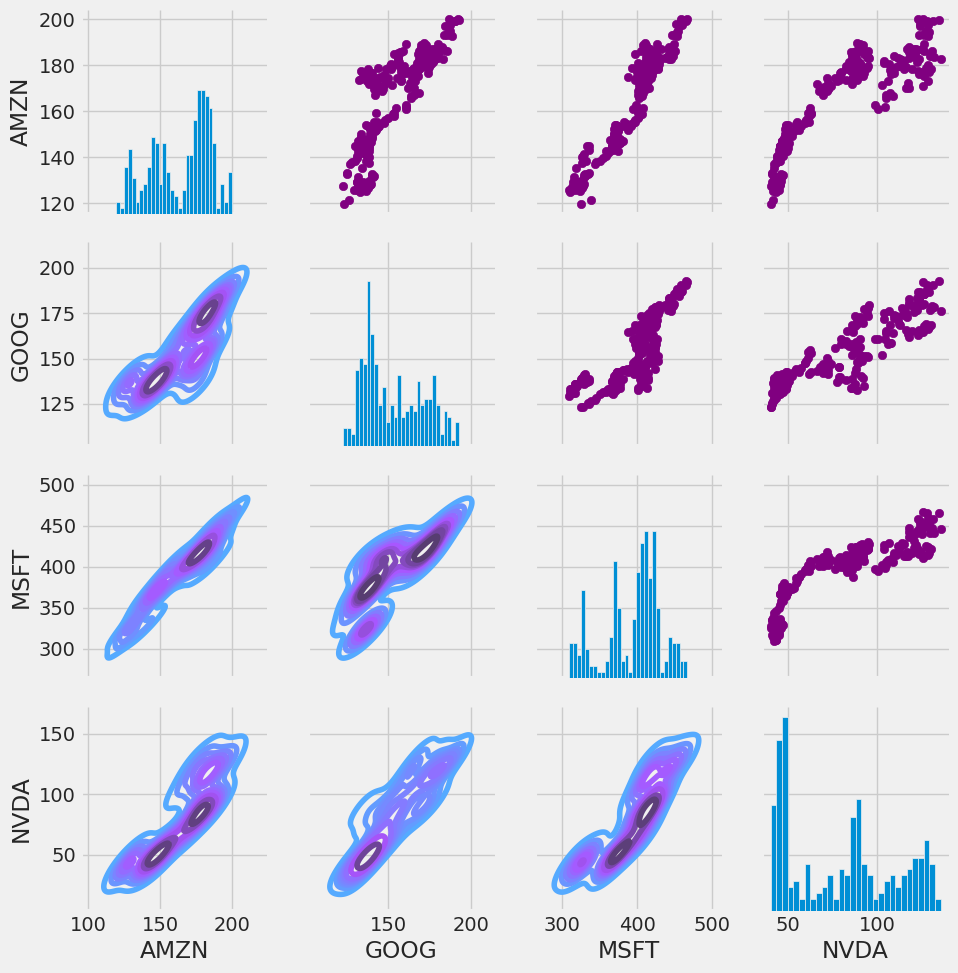

In [18]:
returns_fig = sns.PairGrid(closing_df)

returns_fig.map_upper(plt.scatter, color = 'purple')
returns_fig.map_lower(sns.kdeplot, cmap = 'cool_d')

returns_fig.map_diag(plt.hist, bins = 30)

Text(0.5, 1.0, 'Correlation of stock closing price')

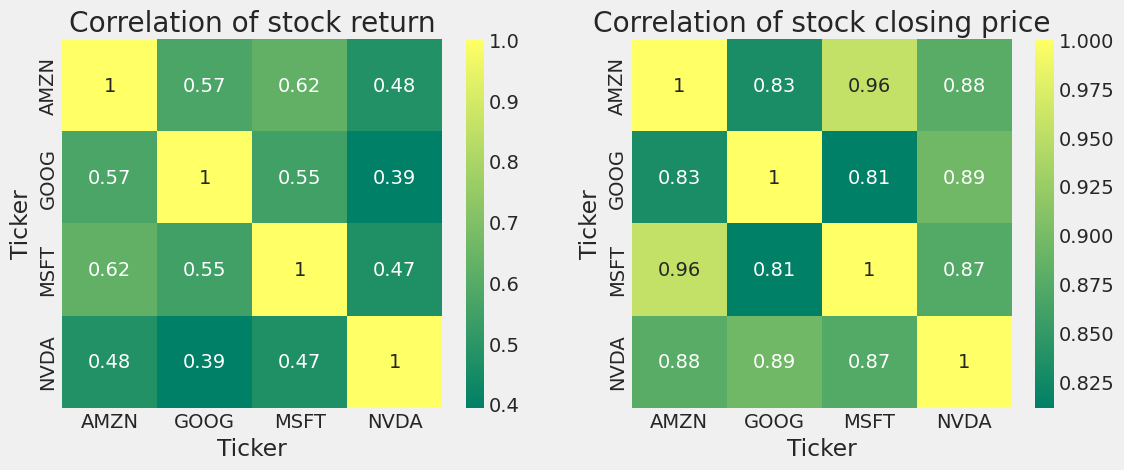

In [19]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_returns.corr(), annot = True, cmap = 'summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot = True, cmap = 'summer')
plt.title('Correlation of stock closing price')

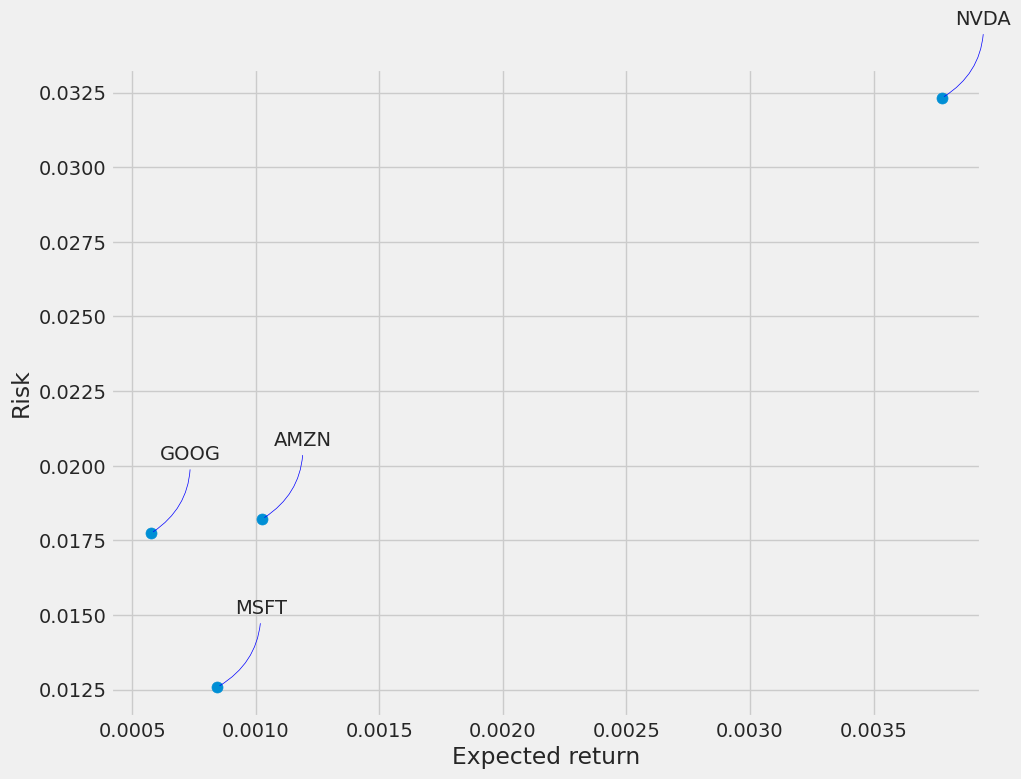

In [20]:
# how much value do we put at risk by investing in these
returns = tech_returns.dropna()
area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(returns.mean(), returns.std(), s= area)
plt.xlabel('Expected return')
plt.ylabel('Risk')


for label, x, y in zip(returns.columns, returns.mean(), returns.std()):
    plt.annotate(label, xy = (x, y), xytext=(50, 50), textcoords = 'offset points', ha = 'right', va = 'bottom'
                    ,arrowprops = dict(
                        arrowstyle = '-',
                        color = 'blue',
                        connectionstyle = 'arc3, rad = -0.3'
                    )
                )

# Predict

In [21]:
# Predicting the closing price of APPLE inc

In [22]:
df = yf.download('NVDA', start= '2012-01-01', end= datetime.now())
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,0.35750,0.36000,0.35025,0.35100,0.321947,468044000
2012-01-04,0.35125,0.35650,0.34800,0.35500,0.325616,347372000
2012-01-05,0.35325,0.36950,0.35175,0.36775,0.337310,563548000
2012-01-06,0.36750,0.36775,0.35925,0.36350,0.333412,533252000
2012-01-09,0.36375,0.37050,0.36100,0.36350,0.333412,508244000


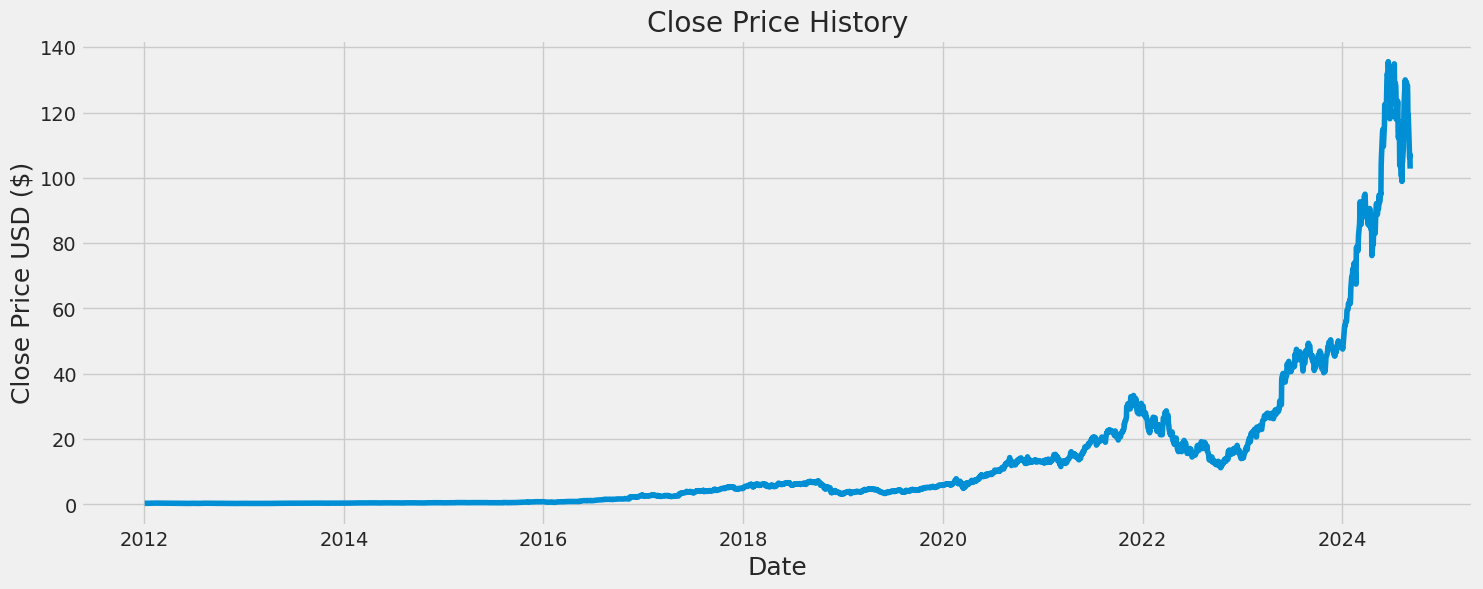

In [23]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

In [24]:
data = df.filter(['Close'])
dataset = data.values

train_len = int(np.ceil(len(dataset) * .95))
train_len

3031

In [25]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[4.91516770e-04],
       [5.21081525e-04],
       [6.15319689e-04],
       ...,
       [7.82919592e-01],
       [7.90310821e-01],
       [7.57937259e-01]])

In [26]:
train_data = scaled_data[0:int(train_len),:]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [27]:
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(x_train, y_train, batch_size = 1, epochs = 1)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2971/2971 ━━━━━━━━━━━━━━━━━━━━ 115s 38ms/step - loss: 6.9014e-04


In [28]:
test_data = scaled_data[train_len - 60:, :]
x_test = []
y_test = dataset[train_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


6.799305213134644

/tmp/ipykernel_17/1866265236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


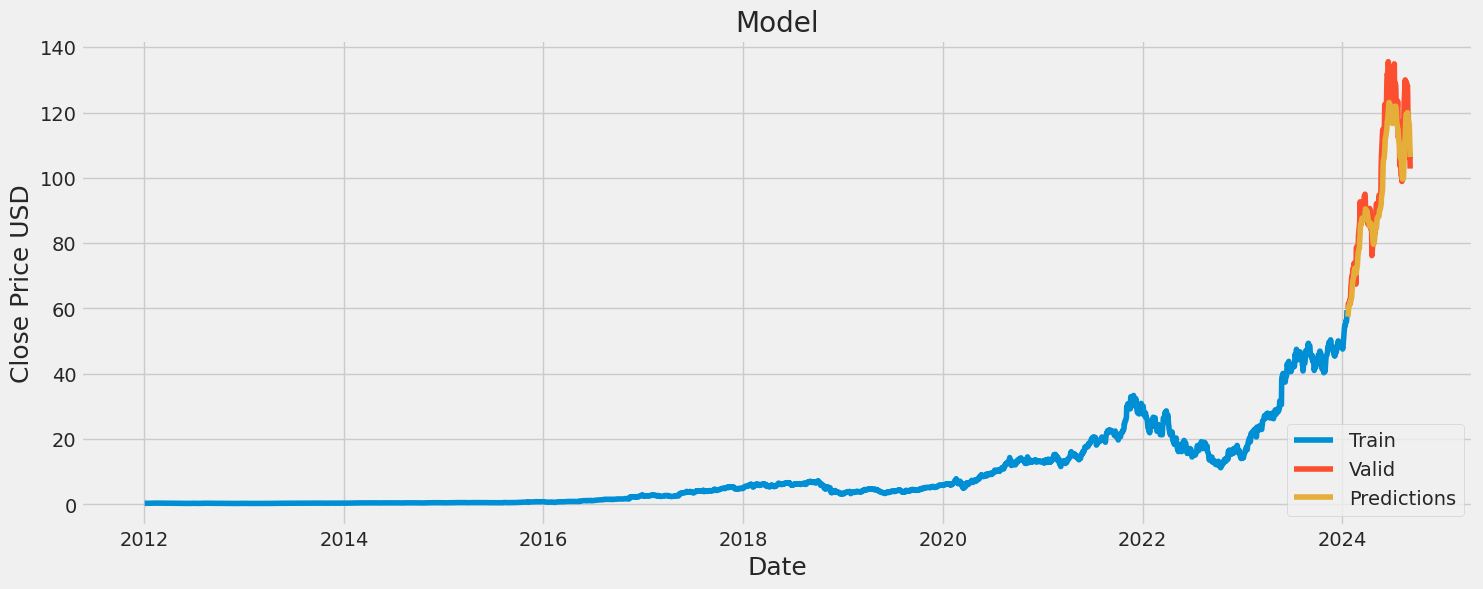

In [29]:
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')
plt.show()

In [30]:
valid

,Close,Predictions
Date,,
2024-01-22,59.653999,57.470184
2024-01-23,59.873001,58.366604
2024-01-24,61.362000,59.123623
2024-01-25,61.617001,59.949108
2024-01-26,61.030998,60.687408
...,...,...
2024-08-30,119.370003,117.680313
2024-09-03,108.000000,115.990494
2024-09-04,106.209999,112.690491


# Reference

- https://www.kaggle.com/code/faressayah/stock-market-analysis-prediction-using-lstm/notebook
- https://aroussi.com/post/python-yahoo-finance
- https://www.investopedia.com/terms/c/correlation.asp
- 